![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [16]:
bikes.groupby('season').total.describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


**INFERENCIAS VARIABLE "season"**

Para esta variable encontramos que en sus 4 categorías se encuentran cercanas en su media, menos el caso de invierno que podemos entender que rentan menos bicicletas por los climas que se dan en estas temporadas, y por el contrario encontramos una media más alta en verano.

De las otras estadísticas encontramos que el mínimo de renta en una hora es de al menos una bicicleta y llegando máximos de más de 800, sin embargo por los percentiles podemos ver que los datos se encuentran distribuidos en las 4 estaciones de manera proporcional lo que nos puede decir que los datos tienen una alta variabilidad, esto también lo podemos ver con el valor de la desviación estándar, donde encontramos valores muy similares a la media.

In [14]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [15]:
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


**INFERENCIAS VARIABLE "hour"**

Para esta variable encontramos que en las 23 horas del día hay una distribución que va aumentando a medida que se acerca las horas laborales, es posible que estos picos a las 8 am y 5 pm se deba a que las personas rentan las bicicletas para ir y volver del trabajo o estudio.

Por otro lado vemos que en el caso de los valores mínimos en todas las horas hay al menos una bicicleta rentada, pero encontramos los mínimos más altos hacia las 10 am y 6 pm, pero los máximos los volvemos a encontrar como en el caso de la media, esto nos dice que sigue el patrón de las horas donde la gente se moviliza hacia y desde sus lugares de trabajo o estudio.

Aunque se debe tener en cuenta que en estas horas también se encuentra la mayor desviación estándar y los percentiles más amplios, lo que nos dice que tienen alta variabilidad, esto podemos pensar que se debe a los días que son de descanso como sábados y domingos, donde normalmente las horas donde se movilizan las personas tienden a otras horas del día.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

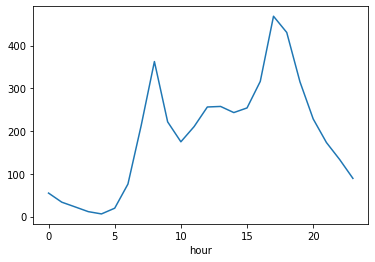

In [17]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

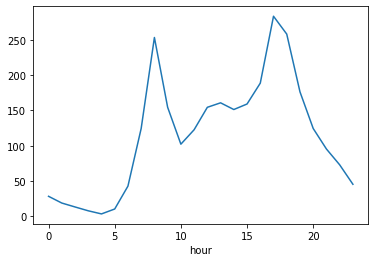

In [22]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes.season == 1].groupby('hour').total.mean().plot()

**INVIERNO**

En la gráfica de invierno encontramos que hay picos en las horas de 7 u 8 de la mañana y en la tarde entre 5 y 6 pm, sin embargo lo más importante es que este comportamiento es muy parecido a la media teniendo en cuenta todas las estaciones, significa que por ser invierno no cambia la dinámica de la renta, lo que cambia son los rangos de los valores máximos y mínimos de la media.


<AxesSubplot:xlabel='hour'>

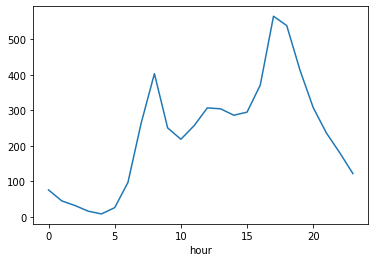

In [23]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes.season == 3].groupby('hour').total.mean().plot()

**VERANO**

Muy similar a lo que ocurre en invierno encontramos un comportamiento muy similar a cuando se tienen en cuenta todas las estaciones, lo que si vemos diferente es los rangos en comparación con la primer gráfica, en verano en comparación con otras estaciones seguramente se da mayor cantidad de renta de bicicletas, que seguramente se da por el clima que se tiene en verano.


**HALLAZGOS COMPARACION**

Viendo las gráficas de la cantidad de rentas en las horas de todas las estaciones y divididas en invierno y verano podemos ver que las gráficas son similares, esto seguramente porque su comportamiento es muy similar, las personas rentan las bicicletas para movilizarse a sus lugares de trabajo o estudio.

En donde se ve la diferencia es en la magnitud de la media de rentas por cada hora en invierno y verano, donde los valores mayores de la media se encuentran en invierno por encima de los 250 pero debajo de los 300, pero en verano vemos valores mayores a 400, esto nos dice que las personas en invierno prefieren no rentar bicicletas muy probablemente por el clima.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [186]:
# Celda 3
y = bikes['total']
X = bikes[['season','hour']]
regLineal = LinearRegression()
regLineal.fit(X,y)
predLineal = regLineal.predict(X)
mse_lineal = np.average(np.square(predLineal-y.values))
regLineal.coef_

array([26.95130851, 10.52129824])

**COEFICIENTES Y LIMITACIONES DEL MODELO DE REGRESIÓN LINEAL**

COEFICIENTES

El coeficiente para la variable “season” es de 26.05, esto significa que empezando en invierno aumenta la renta de bicicletas en 26, es decir si pasamos de invierno a primavera la cantidad de bicicletas rentadas aumenta en 26.

Para el caso de la variable “hour” es más fácil de interpretar teniendo en cuenta que por cada hora que avanza el día aumenta la cantidad de renta de bicicletas en 10.52.

LIMITACIONES

Sin embargo teniendo en cuenta estos coeficientes vemos que el modelo lineal tiene un limitación y es que viendo los análisis que realizamos anteriormente no es correcto decir que entre la estación verano y otoño la cantidad de renta aumenta, ya que vimos que disminuye.

Y por otro lado para las horas el modelo no logra tomar los cambios en la tendencia horaria, donde no siempre entre más avanzadas las horas del día se rentan más bicicletas, esto teniendo en cuenta que se llega a dos picos cercanos a las 8 am y 5 pm, y que después de estas horas la cantidad de rentas disminuye.


### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [184]:
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    best_split = [0, 0, 500000000]  # j, split, mse
    # Para todas las varibles 
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            filter_l = X.iloc[:,j] < split
            y_l = y.loc[filter_l]
            y_r = y.loc[~filter_l]
            mse = np.average(np.square(y_l.mean()-y))
            
            if (mse < best_split[2]):
                best_split = [j, split, mse]
    
    return best_split

def tree_grow(X, y, level=0, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=y.mean(), level=level, split=-1, n_samples=1,mse=0)
        return tree
    
    # Calcular la mejor división
    j, split, mse = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean()) 
    y_prob = (y.sum()+1) / (y.shape[0]+2)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0],mse=mse)
    # Revisar el criterio de parada 
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [202]:
tree = tree_grow(X, y, level=0, max_depth=3, num_pct=10)
tree

{'y_pred': 191,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [1, 19.0],
 'n_samples': 10886,
 'mse': 32811.17037785508,
 'sl': {'y_pred': 192,
  'y_prob': 192.46305762081784,
  'level': 1,
  'split': [0, 4.0],
  'n_samples': 8606,
  'mse': 37068.30120605564,
  'sl': {'y_pred': 188,
   'y_prob': 188.45965238981998,
   'level': 2,
   'split': [0, 3.0],
   'n_samples': 6442,
   'mse': 37515.26728817723,
   'sl': {'y_pred': 167,
    'y_prob': 167.57696799813127,
    'level': 3,
    'split': -1,
    'n_samples': 4279,
    'mse': 33070.772056793336},
   'sr': {'y_pred': 229,
    'y_prob': 229.578752886836,
    'level': 3,
    'split': -1,
    'n_samples': 2163,
    'mse': 45349.705809087834}},
  'sr': {'y_pred': 204,
   'y_prob': 204.19621421975992,
   'level': 2,
   'split': [1, 17.0],
   'n_samples': 2164,
   'mse': 37661.817423900895,
   'sl': {'y_pred': 174,
    'y_prob': 174.53818369453043,
    'level': 3,
    'split': -1,
    'n_samples': 1936,
    'mse': 28554.549715041507},


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

Text(0, 0.5, 'MSE')

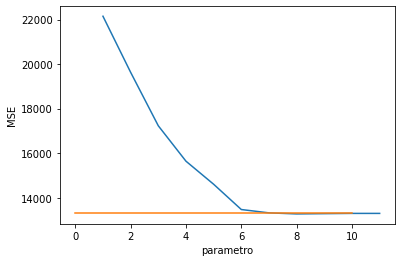

In [81]:
# Celda 5

# Se separan los datos en train y text
from sklearn.model_selection import train_test_split
XTrain, XTest, yTrain, yTest = train_test_split(X,y,test_size=0.30, random_state=0)

# Haremos calibración del modelo con los parametros de max_depth y min_samples_leaf
max_depth_range = range(1, 12)
min_samples_leaf_range = range(1, 12)
mse_depth = []
mse_leaf = []

# Generamos el ciclo para evaluar con cada parametro
for depth in max_depth_range:
    reg = DecisionTreeRegressor(max_depth=depth, random_state=0)
    reg.fit(XTrain,yTrain)
    pred = reg.predict(XTest)
    mse_depth.append(np.average(np.square(pred-yTest.values)))

for leaf in min_samples_leaf_range:
    reg = DecisionTreeRegressor(min_samples_leaf=leaf, random_state=0)
    reg.fit(XTrain,yTrain)
    pred = reg.predict(XTest)
    mse_leaf.append(np.average(np.square(pred-yTest.values)))

import matplotlib.pyplot as plt
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, mse_depth, mse_leaf)
plt.xlabel('parametro')
plt.ylabel('MSE')

In [82]:
regDT = DecisionTreeRegressor(max_depth=8, min_samples_leaf=6, random_state=0)
regDT.fit(XTrain,yTrain)
predDT = regDT.predict(XTest)
MSEDT=np.average(np.square(predDT-yTest.values))
print('MSE del árbol de decisión de regresión:')
print(MSEDT)
print('MSE de la regresión lineal:')
print(mse_lineal)

MSE del árbol de decisión de regresión:
13275.45349461614
MSE de la regresión lineal:
26640.03254457677


**METRICA Y COMPARACIÓN CON LA REGRESIÓN LINEAL**

Como podemos ver para el caso de la regresión calculamos el MSE que para el árbol de decisión de regresión es de 13275 y para el modelo de regresión lineal es de 26640, encontrando que tenemos un mayor desempeño en el modelo de árbol de decisión, siendo esta diferencia en los errores de casi el doble, por esto encontramos que para este caso es mejor el modelo de árbol de decisión.


## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [83]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [84]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [85]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

Text(0, 0.5, 'Accuracy')

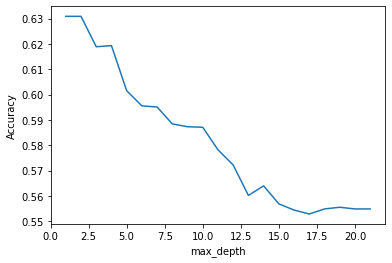

In [91]:
# Celda 6
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Haremos calibración del modelo con los parametros de max_depth
max_depth_range = range(1, 22)
accuracy_scores = []

# Generamos el ciclo para evaluar con cada parametro
for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

import matplotlib.pyplot as plt
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [99]:
from sklearn.metrics import f1_score, accuracy_score

clfRegLog = LogisticRegression(random_state=0)
clfRegLog.fit(X_train,y_train)
predRegLog = clfRegLog.predict(X_test)

f1_RegLog = f1_score(y_true=y_test.values, y_pred=predRegLog)
accuracy_RegLog = accuracy_score(y_true=y_test, y_pred=predRegLog)

clfDT = DecisionTreeClassifier(max_depth=1, random_state=0)
clfDT.fit(X_train,y_train)
pred_clfDT = clfDT.predict(X_test)

f1_DT = f1_score(y_true=y_test.values, y_pred=pred_clfDT)
accuracy_DT = accuracy_score(y_true=y_test.values, y_pred=pred_clfDT)

print("\nEl Accuracy de la regresión logística es: "+str(accuracy_RegLog))
print("\nY el F1-Score de la regresión logística es: "+str(f1_RegLog))

print("\nEl Accuracy del árbol de decisión de clasificación con una profundidad de 1 es: "+str(accuracy_DT))
print("\nY el F1-Score del árbol de decisión de clasificación con una profundidad de 1 es: "+str(f1_DT))


El Accuracy de la regresión logística es: 0.6146666666666667

Y el F1-Score de la regresión logística es: 0.6110363391655451

El Accuracy del árbol de decisión de clasificación con una profundidad de 1 es: 0.6453333333333333

Y el F1-Score del árbol de decisión de clasificación con una profundidad de 1 es: 0.6448598130841121


**COMPARACIÓN ACCURACY Y F1-SCORE**

Como podemos ver los resultados de los accuracy y el f1-score, encontramos que la diferencia entre los modelos es pequeña, pero sigue siendo mejor el modelo de árboles de decisión, donde encontramos los mejores accuracy y f1-score, con valores de 0.64. Esto nos indica que el modelo de arboles de decisión se equivoca menos veces


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [150]:
# Celda 7
from sklearn.ensemble import BaggingClassifier
#Primer Modelo
clfBag1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100,max_samples=300, bootstrap=True,
                        random_state=0, n_jobs=-1, oob_score=True)

clfBag2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=8), n_estimators=100,max_samples=300, bootstrap=True,
                        random_state=0, n_jobs=-1, oob_score=True)

clfBag3 = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100,max_samples=300, bootstrap=True,
                        random_state=0, n_jobs=-1, oob_score=True)

def evalua_modelo(modelo,XTrain,yTrain,XTest,yTest):
    modelo.fit(XTrain,yTrain)
    pred = modelo.predict(XTest)
    f1 = f1_score(y_true=yTest.values, y_pred=pred)
    accuracy = accuracy_score(y_true=yTest, y_pred=pred)
    return accuracy, f1

metricas = []
metricas.append(evalua_modelo(clfBag1,X_train,y_train,X_test,y_test))
metricas.append(evalua_modelo(clfBag2,X_train,y_train,X_test,y_test))
metricas.append(evalua_modelo(clfBag3,X_train,y_train,X_test,y_test))
i=1
for m in metricas:
    print("\nEl Accuracy del "+ str(i) +" modelo es: "+str(m[0]))
    print("\nY el F1-Score del "+ str(i) +" modelo es: "+str(m[1]))
    i+=1



El Accuracy del 1 modelo es: 0.656

Y el F1-Score del 1 modelo es: 0.6546184738955824

El Accuracy del 2 modelo es: 0.6673333333333333

Y el F1-Score del 2 modelo es: 0.6662207357859532

El Accuracy del 3 modelo es: 0.622

Y el F1-Score del 3 modelo es: 0.6161137440758294


In [151]:
def prediccion(modelo,XTrain,yTrain,XTest):
    modelo.fit(XTrain,yTrain)
    pred = modelo.predict(XTest)
    return pred

predBagTemp = (prediccion(clfBag1,X_train,y_train,X_test) + prediccion(clfBag2,X_train,y_train,X_test) + prediccion(clfBag3,X_train,y_train,X_test))/3
prediccionBag = np.where(predBagTemp < 0.5, 0, 1)
accuracyEnsamble = accuracy_score(y_true=y_test, y_pred=prediccionBag)
f1Ensamble = f1_score(y_true=y_test.values, y_pred=prediccionBag)
print("\nEl Accuracy del modelo ensamblado es: "+str(accuracyEnsamble))
print("\nY el F1-Score del modelo ensamblado es: "+str(f1Ensamble))


El Accuracy del modelo ensamblado es: 0.6573333333333333

Y el F1-Score del modelo ensamblado es: 0.6554959785522789


**COMPARACIÓN DE LOS MODELOS**

Comparando las métricas de accuracy y f1-score vemos que los dos modelos con arboles de decisión dan una mejor clasificación y que la regresión logística nos da métricas menores, que viéndolo en el modelo ensamblado podemos ver que las métricas no mejoran, esto seguramente porque tenemos un modelo que se desempeña peor que los otros dos, sin embargo sigue dando un resultado muy cercano a los modelos individuales de arboles.


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [152]:
# Celda 8
def votacion_ponderada(modelo,X_test,X_train,y_train):
    errors = np.zeros(modelo.n_estimators)
    y_pred_all_ = np.zeros((X_test.shape[0], modelo.n_estimators))

    for i in range(modelo.n_estimators):
        oob_sample = ~modelo.estimators_samples_[i]
        y_pred_ = modelo.estimators_[i].predict(X_train.values[oob_sample])
        errors[i] = accuracy_score(y_pred_, y_train.values[oob_sample])
        y_pred_all_[:, i] = modelo.estimators_[i].predict(X_test)

    alpha = (1 - errors) / (1 - errors).sum()
    y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)
    return y_pred

prediccion = []
prediccion.append(votacion_ponderada(clfBag1,X_test,X_train,y_train))
prediccion.append(votacion_ponderada(clfBag2,X_test,X_train,y_train))
prediccion.append(votacion_ponderada(clfBag3,X_test,X_train,y_train))

i=1
metricas2 =[]
for pred in prediccion:
    f1 = f1_score(y_true=y_test.values, y_pred=pred)
    accuracy = accuracy_score(y_true=y_test, y_pred=pred)
    metricas2.append((accuracy,f1))
    print("\nEl Accuracy del "+ str(i) +" modelo es: "+str(accuracy))
    print("\nY el F1-Score del "+ str(i) +" modelo es: "+str(f1))
    i+=1


El Accuracy del 1 modelo es: 0.6486666666666666

Y el F1-Score del 1 modelo es: 0.6342817487855656

El Accuracy del 2 modelo es: 0.656

Y el F1-Score del 2 modelo es: 0.6416666666666666

El Accuracy del 3 modelo es: 0.6193333333333333

Y el F1-Score del 3 modelo es: 0.610770279481936


In [153]:
predBagTemp2 = (prediccion[0] + prediccion[1] + prediccion[2])/3
prediccionBag2 = np.where(predBagTemp2 < 0.5, 0, 1)
accuracyEnsamble2 = accuracy_score(y_true=y_test, y_pred=prediccionBag2)
f1Ensamble2 = f1_score(y_true=y_test.values, y_pred=prediccionBag2)
print("\nEl Accuracy del modelo ensamblado es: "+str(accuracyEnsamble2))
print("\nY el F1-Score del modelo ensamblado es: "+str(f1Ensamble2))


El Accuracy del modelo ensamblado es: 0.654

Y el F1-Score del modelo ensamblado es: 0.6403326403326404


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

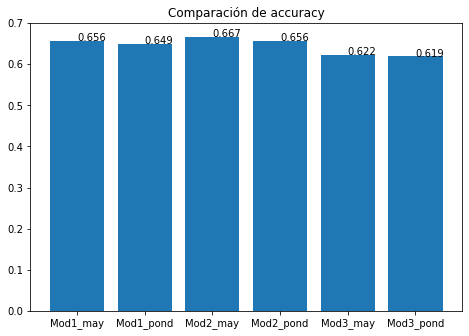

In [154]:
# Celda 9
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de accuracy")
ejeX = ['Mod1_may', 'Mod1_pond', 'Mod2_may', 'Mod2_pond','Mod3_may', 'Mod3_pond']
ejeY = [round(metricas[0][0],3), round(metricas2[0][0],3), round(metricas[1][0],3), round(metricas2[1][0],3),round(metricas[2][0],3), round(metricas2[2][0],3)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()   

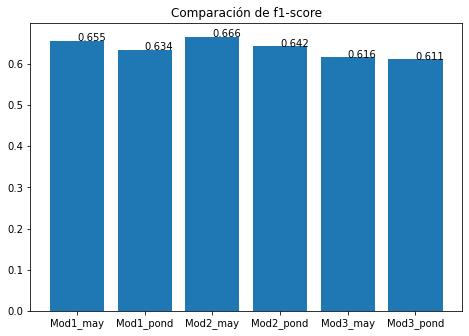

In [155]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de f1-score")
ejeX = ['Mod1_may', 'Mod1_pond', 'Mod2_may', 'Mod2_pond','Mod3_may', 'Mod3_pond']
ejeY = [round(metricas[0][1],3), round(metricas2[0][1],3), round(metricas[1][1],3), round(metricas2[1][1],3),round(metricas[2][1],3), round(metricas2[2][1],3)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()   

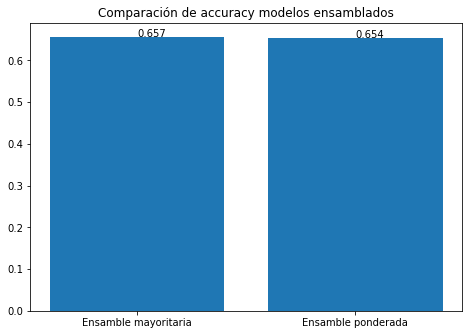

In [156]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de accuracy modelos ensamblados")
ejeX = ['Ensamble mayoritaria', 'Ensamble ponderada']
ejeY = [round(accuracyEnsamble,3), round(accuracyEnsamble2,3)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show() 

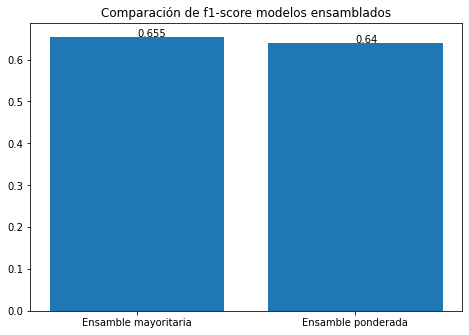

In [157]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de f1-score modelos ensamblados")
ejeX = ['Ensamble mayoritaria', 'Ensamble ponderada']
ejeY = [round(f1Ensamble,3), round(f1Ensamble2,3)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show() 

**COMPARACIÓN DESEMPEÑO DE LOS MODELOS**

Viendo las gráficas que se presentaron vemos que en general el desempeño de los modelos de votación mayoritaria da mejores métricas del accuracy y del f1-score, es así que debemos tener en cuenta es que cuando se realiza el ensamble los modelos de votación ponderada si mejoran su predicción, en cambio en votación mayoritaria lo baja o lo mantiene.

Por esto en escenarios con modelos de ensamble con mayor diferencia en sus métricas es mejor usar la votación ponderada.
